# Online Retail Store - Exploration Data Analysis

This notebook is a continuation of the <a href="https://github.com/BAinebyona/BusinessAnalytics/tree/main/Online_Retail">Business Analytics project</a> on Online Retail store.
In this notebook we carry out exploration data analysis to gain insights and answer possible business questions. 

## Business questions
1. Most important countries(measured by customers)
2. New Customer registration growth (Month-on-Month)
3. Number customers placing orders (Month-on-Month)
4. Revenue growth trend
5. Most important products and year-on-year growth in revenue from these products

## Dataset 
Two years (Dec-2009 to Dec-2011) of transactions data from a small UK-based non-store business will be used in this project. The data is available at <a href = "https://www.kaggle.com/code/ekrembayar/rfm-analysis-online-retail-ii"> Online Retail II dataset</a>. It is provided as an excel format in two sheets, `Year 2009-2010` and `Year 2010-2011`by <a href = "https://www.kaggle.com/datasets/kabilan45/online-retail-ii-dataset">Kabilan, (2019)</a> (excel_data). 
### what we learnt from data cleaning
- There is an overlap in the dataset at the end of `Year 2009-2010` and beginning of `Year 2010-2011` which should be removed
- There appears to be duplicates in the data. However, these are uniformly distributed through time. We leave these in the dataset as we have no way of confirming what they represent
- Invoices are either 6 characters(all digits) or seven characters (six digits with a preceding letter **C** or **A**)
    - Invoices starting with **A** appear to be simply accounting items and are typically associated with negative `Price` apart from invoice **A563185**. There is need to remove these records from the customer related analysis in this notebook.
    - Invoices starting with **C** are cancellations. They appear to be associated with negative values of `Quantity`, although not always. see Invoice **C496350**. It is important to note that when Invoice starts with **C** but `Quantity` is positive, then Customer ID is null. 

- There is no relationship between the invoice numbers assigned to cancellations and their original purchase invoices. for example invoice **C541433** appears to be a cancellation of **541431**. It is therefore not possible to group cancellations with associated purchases.

- Negative values of `Quantity` represent more than just returns but other cancelled sales relating to bad items for example.
- there is 22.8% missing entries in `Customer ID` column. This is a relatively large proportion of misssing data. In this project, we assume that they represent unregistered customers who could potentially not be assigned an ID. This something that we would have to check with the team in charge of this data collection. 

We shall use these lessons in shaping the data depending on the analysis

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator,FixedFormatter)
import seaborn as sns
import matplotlib.style as style
%matplotlib inline

## Read the data

In [2]:
# read the excel data from the two sheets and concatenate into one dataset
excel_data_part1 = pd.read_excel('./dataset/online_retail_II.xlsx', sheet_name = 'Year 2009-2010')
excel_data_part2 = pd.read_excel('./dataset/online_retail_II.xlsx', sheet_name = 'Year 2010-2011')

## Data cleaning

I have previously performed extensive data cleaning of this dataset in a separate notebook `Online_Retail_Data_cleaning` in this project. Please refer to it for explanation of the data processing steps.  

There is an overlap in the dataset at the end of `Year 2009-2010` and beginning of `Year 2010-2011` which we filter out before joininig the data from the two excel sheets into one dataframe 

In [90]:
excel_data_part2_minDate = excel_data_part2['InvoiceDate'].min() # start date of the second part of the dataset
# merged excel_data
df = pd.concat(
    [excel_data_part1[excel_data_part1['InvoiceDate'] < excel_data_part2_minDate],
     excel_data_part2
    ])
df.shape

(1044848, 8)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044848 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1044848 non-null  object        
 1   StockCode    1044848 non-null  object        
 2   Description  1040573 non-null  object        
 3   Quantity     1044848 non-null  int64         
 4   InvoiceDate  1044848 non-null  datetime64[ns]
 5   Price        1044848 non-null  float64       
 6   Customer ID  809561 non-null   float64       
 7   Country      1044848 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 71.7+ MB


In [94]:
# set string dtype for relevant columns
str_columns = ['Invoice', 'StockCode', 'Description', 'Country']
for col in str_columns:
    df[col] = df[col].astype(str)

# rename column for easy typing
df.rename(columns={'Customer ID' : 'CustomerID'}, inplace=True)

In [23]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [17]:
df[(df['Invoice'].str[0] == 'C')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [24]:
df[(df['Invoice'].str[0] == 'A')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


We start by creating two functions to process the data i

In [25]:
def return_positive_orders(df):
    '''return only positive value orders'''   
    positive_orders = df.copy()
    positive_orders = positive_orders[(~positive_orders['Invoice'].str.contains('C', na = False))] # remove cancellations
    positive_orders = positive_orders[(~positive_orders['Invoice'].str.contains('A', na = False))] # remove accounting invoices
    # remove any other cancelled orders such as crushed items - represented negative quantity
    positive_orders = positive_orders[(positive_orders['Quantity'] >= 0)]
    return positive_orders

def return_customer_monetary_value(df):
    '''returns monetary value of each customer '''
    customer_data = df.copy()
    customer_data.dropna(subset = ['CustomerID'], inplace=True) # drop all rows with null customer ID
    customer_data['CustomerID'] = customer_data['Customer ID'].astype(int) # set customer ID column to int
    # create TotalValue column = Price * Quantity
    customer_data['TotalValue'] = customer_data['Quantity'] * customer_data['Price']
    monetary_value = return_customer_transactions(df)
    
    monetary_value = customer_data[['Customer ID','TotalValue']
                                  ].groupby('Customer ID').agg(Monetary = ('TotalValue', 'sum'))
    return monetary_value

## Customer growth trends  

## Monthly unique customers
Here we explore the number of unique customers making orders month-on-month. This is to get the growth rate of the customer base

In [141]:
# remove accounting records from the data
customer_data = df[~(df['Invoice'].str[0] == 'A')].copy()   # accounting invoices start with A
customer_data.dropna(subset = ['CustomerID'], inplace=True) # drop all rows with null customer ID
customer_data['CustomerID'] = customer_data['CustomerID'].astype(int)
customer_data['InvoiceYear'] = customer_data['InvoiceDate'].dt.year
customer_data['InvoiceMonth'] = customer_data['InvoiceDate'].dt.month

# get unique customer count in a month

month_customers = customer_data.groupby(
                            ['InvoiceYear', 'InvoiceMonth'], as_index=False
                            ).agg(n_customers = ('CustomerID', 'nunique'))

month_customers.head()

,InvoiceYear,InvoiceMonth,n_customers
0,2009,12,1045
1,2010,1,786
2,2010,2,807
3,2010,3,1111
4,2010,4,998


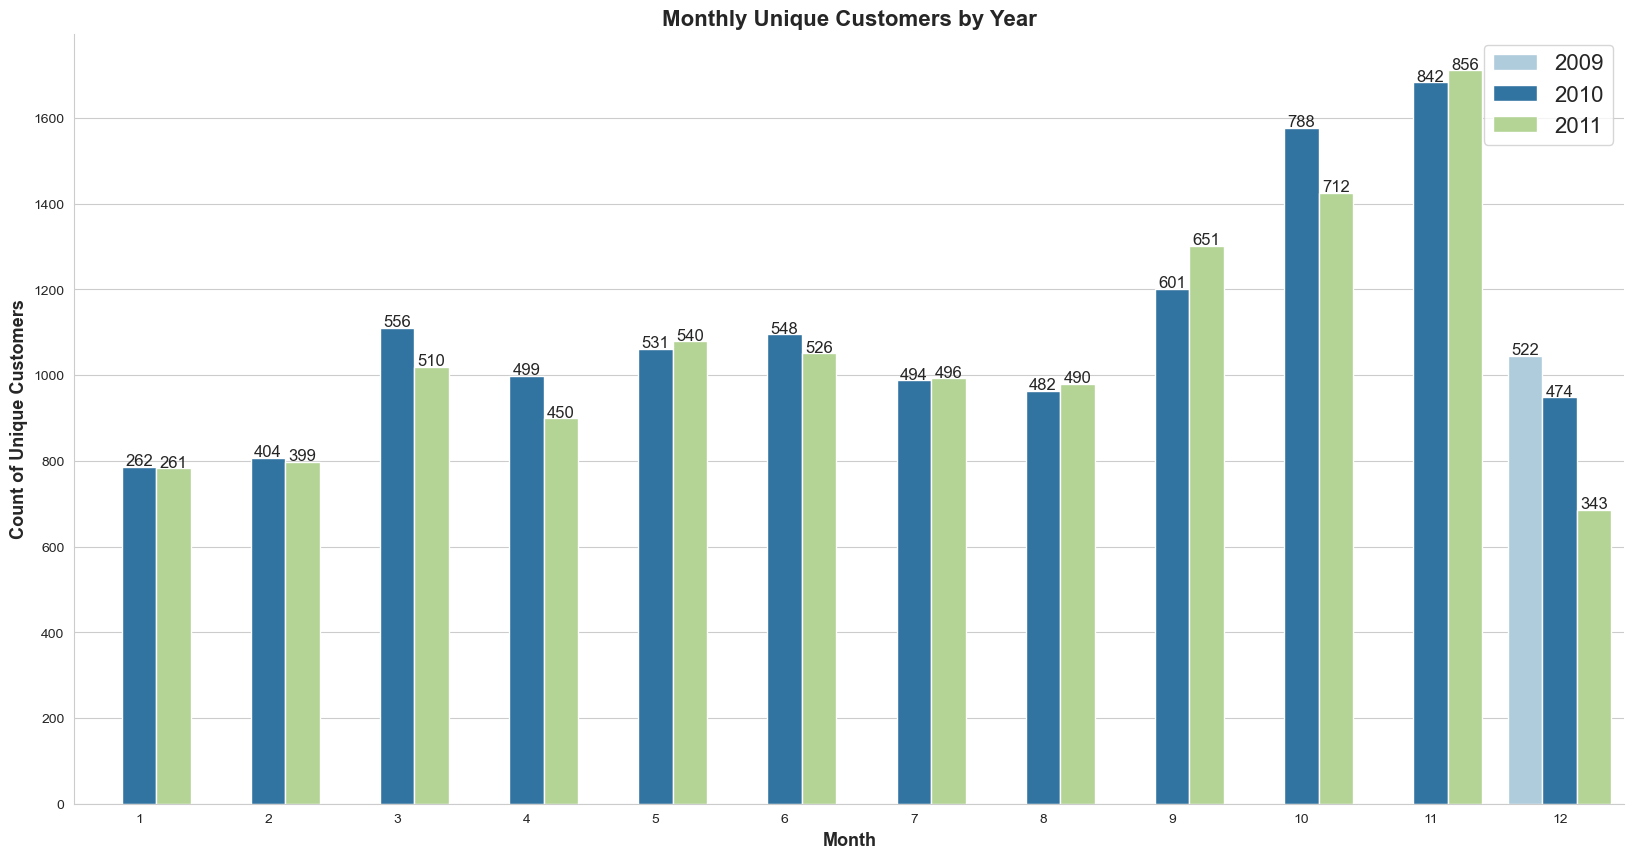

In [142]:
# plot unique customers
sns.set_style('whitegrid')  # set theme
fig, ax = plt.subplots(figsize=(20,10))

# Create barplot
chart1 = sns.barplot(data=month_customers, x='InvoiceMonth',y='n_customers', hue ='InvoiceYear', palette = 'Paired', ax=ax)
# Customize chart
chart1.set_ylabel('Count of Unique Customers',weight='bold',fontsize=13)
chart1.set_xlabel('Month', weight='bold',fontsize=13)
chart1.set_title('Monthly Unique Customers by Year',weight='bold',fontsize=16)
chart1.legend(loc='upper right', fontsize =16)
sns.despine(left = False)

# Create value label on bar chart
totals = month_customers['InvoiceMonth'].value_counts()
n_hues = month_customers['InvoiceYear'].unique().size

temp_totals = totals.values.tolist() * n_hues
for p, t in zip(ax.patches, temp_totals):
    height = p.get_height()
    if p.get_height() > 0:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
        height + 3,
        '{:1.0f}'.format(height / t),
        ha="center", fontsize=12)

plt.show()

Next we look at the most important countries in terms of number of customers

In [154]:
# customers per country
customers_per_country = customer_data.groupby('Country', as_index=False).agg(CustomerCount=('CustomerID', 'nunique'))
customers_per_country.sort_values(by='CustomerCount', ascending=False, inplace=True)

# get the ratio of total
customers_per_country['pct_total'] = customers_per_country['CustomerCount'] *100 / customers_per_country['CustomerCount'].sum()
customers_per_country.reset_index(drop=True, inplace=True)
customers_per_country.iloc[:12]

,Country,CustomerCount,pct_total
0,United Kingdom,5410,90.848027
1,Germany,107,1.796809
2,France,95,1.595298
3,Spain,41,0.688497
4,Belgium,29,0.486986
5,Portugal,24,0.403023
6,Netherlands,23,0.386230
7,Switzerland,22,0.369437
8,Sweden,19,0.319060
9,Italy,17,0.285474


~91% of the customers are in the United Kingdom. Outside the main UK market there is only handful of 

In [174]:
customers_annual_growth = customer_data.groupby(['Country', 'InvoiceYear']).agg(CustomerCount=('CustomerID', 'nunique'))
customers_annual_growth = customers_annual_growth.unstack('InvoiceYear')
customers_annual_growth.columns = customers_annual_growth.columns.droplevel(0)
customers_annual_growth['total_customers'] = customers_annual_growth.sum(axis=1)

# compute percent change in customer base per country from 2010 to 2011
customers_annual_growth['pct_change_2010_11'] = (customers_annual_growth.loc[:, 2011] - customers_annual_growth.loc[:, 2010]) * 100 / customers_annual_growth.loc[:, 2010]
customers_annual_growth['pct_change_2010_11'] = customers_annual_growth['pct_change_2010_11'].apply(lambda x: round(x, 2))

# filter to the top 11 important markets
important_markets = customers_per_country.loc[:12, 'Country']
change_important_markets = customers_annual_growth[customers_annual_growth.index.isin(important_markets)].copy()

change_important_markets.sort_values(by='total_customers', ascending=False, inplace=True)
change_important_markets

InvoiceYear,2009,2010,2011,total_customers,pct_change_2010_11
Country,,,,,
United Kingdom,986.0,3940.0,3835.0,8761.0,-2.66
Germany,11.0,70.0,93.0,174.0,32.86
France,13.0,47.0,84.0,144.0,78.72
Spain,5.0,26.0,30.0,61.0,15.38
Belgium,2.0,17.0,25.0,44.0,47.06
Portugal,2.0,18.0,18.0,38.0,0.00
Switzerland,1.0,14.0,21.0,36.0,50.00
Netherlands,2.0,23.0,8.0,33.0,-65.22
Australia,3.0,15.0,9.0,27.0,-40.00


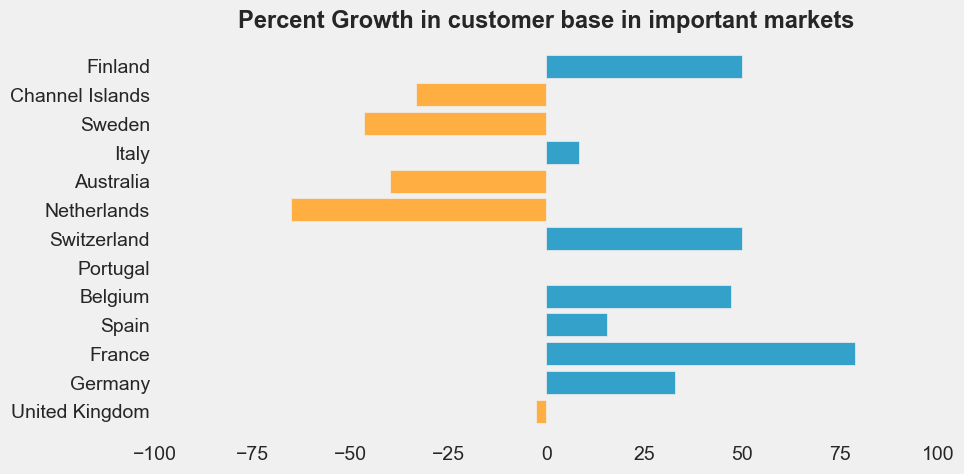

In [179]:
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(9, 5))
positive_clrs = change_important_markets['pct_change_2010_11'] >= 0
color_map = positive_clrs.map({True:'#33A1C9',
                                      False:'#ffae42'}
                                    )
ax.barh(change_important_markets.index, change_important_markets['pct_change_2010_11'], color=color_map)
ax.grid(visible=False)
ax.set_xlim(-100, 100)
ax.set_title('Percent Growth in customer base in important markets',weight = 'bold',size=17)
plt.show()

## Monthly new customer registration  

Here we shall explore trends of how many customers are added Month-on-Month as new customers. The customer registration data is not available. Here, we make an assumption that the first date a customer makes a transactions is the date they were registered.  

It is important to note that there is a large proportion of data with missing customer ID. We first compute proportion of records with missing Customer ID per country. This is necessary to understand the bias in the customer growth we generate.

In [126]:
data = df[~(df['Invoice'].str[0] == 'A')].copy()   # accounting invoices start with A
# missing customerID
no_cust_id = data['CustomerID'].isna().sum()
print('Percentage of transactions without customerID: {:.2f}'.format(no_cust_id * 100 / data.shape[0]))


# proportion of missing customer ID per country
transactions_per_country = data['Country'].value_counts().to_frame().rename(columns={'Country' : 'Transactions'})

country_missing_custId = data['Country'][data['CustomerID'].isna()
                                        ].value_counts().to_frame().rename(columns={'Country' : 'no_custId'})

# proportion of transactions with missing customerID per country
country_prop = transactions_per_country.join(country_missing_custId, how='inner')
country_prop['prop_missing'] = country_prop['no_custId'] / country_prop['Transactions']
country_prop

Percentage of transactions without customerID: 22.52


,Transactions,no_custId,prop_missing
United Kingdom,959977,232314,0.242000
EIRE,17689,1660,0.093844
France,14059,128,0.009104
Switzerland,3183,125,0.039271
Portugal,2540,116,0.045669
Sweden,1364,19,0.013930
Unspecified,756,232,0.306878
United Arab Emirates,500,114,0.228000
Israel,371,47,0.126685
Hong Kong,364,364,1.000000


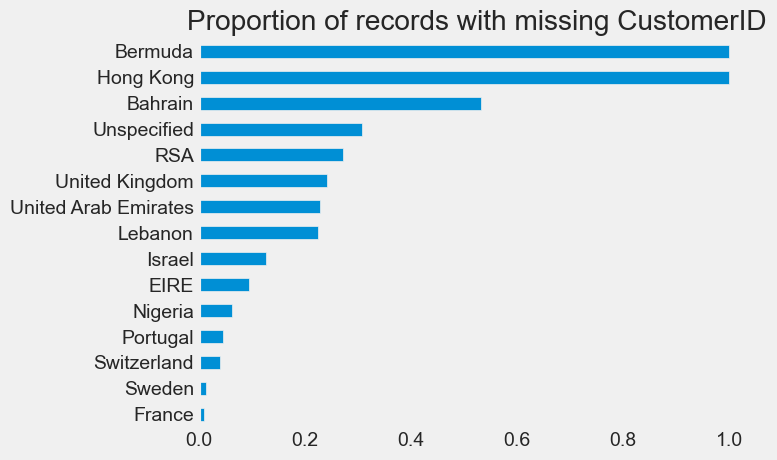

In [181]:
# style.use('fivethirtyeight')
country_prop['prop_missing'].sort_values().plot(kind='barh', title='Proportion of records with missing CustomerID')
plt.grid(visible=False)
plt.show()

Here we can see that in some countries all records contain missing CustomerID. So we know the limitations of the 

In [132]:
# take the first invoice date as the customer registration date 
customer_reg_date = data[['CustomerID', 'InvoiceDate']].dropna()
customer_reg_date['CustomerID'] = customer_reg_date['CustomerID'].astype(int)
customer_reg_date = customer_reg_date[['CustomerID', 'InvoiceDate']
                                     ].groupby('CustomerID', as_index=False).agg(RegDate =('InvoiceDate', 'min'))

# group number of customers in their registration month
customer_reg_date['yy_mm'] = customer_reg_date['RegDate'].dt.to_period('M')
customer_reg_date.head()

,CustomerID,RegDate,yy_mm
0,12346,2009-12-14 08:34:00,2009-12
1,12347,2010-10-31 14:20:00,2010-10
2,12348,2010-09-27 14:59:00,2010-09
3,12349,2009-12-04 12:49:00,2009-12
4,12350,2011-02-02 16:01:00,2011-02


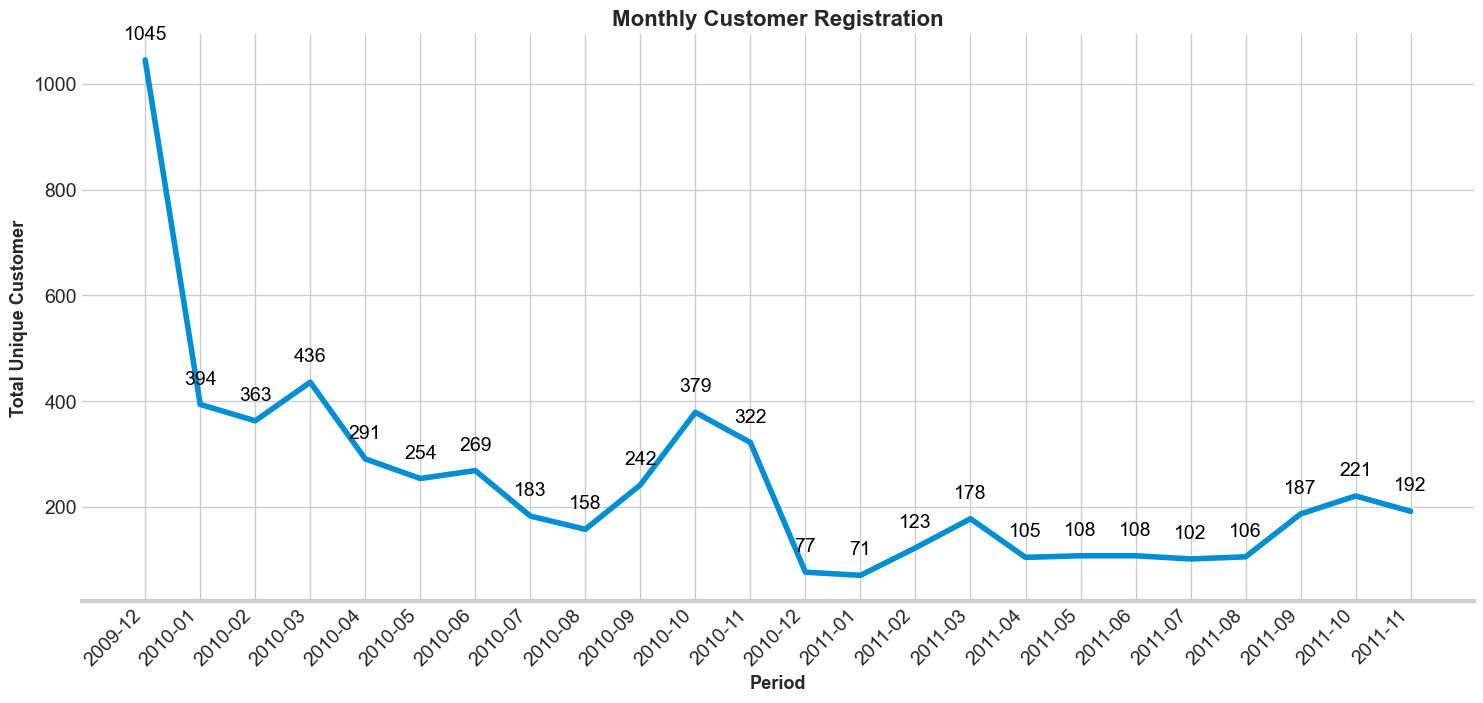

In [182]:
# Month-on-Month Customer Registration
MoM_cust_Reg = customer_reg_date.groupby('yy_mm', as_index=False).agg(CustRegCount = ('CustomerID', 'count'))
MoM_cust_Reg['yy_mm'] = MoM_cust_Reg['yy_mm'].astype(str)

# plot the MoM customer Registration
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,7))
chart = sns.lineplot(data=MoM_cust_Reg.iloc[:-1, :], x='yy_mm', y='CustRegCount', ax=ax)   # remove last 2019-12 from plt
sns.despine(left=True)
# Customize chart
chart.set_xlabel('Period',weight='bold',fontsize=13)
chart.set_ylabel('Total Unique Customer', weight='bold',fontsize=13)
chart.set_title('Monthly Customer Registration',weight='bold',fontsize=16)
chart.xaxis.set_major_locator(FixedLocator(range(MoM_cust_Reg['yy_mm'].shape[0] - 1)))
chart.set_xticklabels(MoM_cust_Reg['yy_mm'].iloc[:-1], rotation = 45, ha="right")

ymin, ymax = ax.get_ylim()
bonus = (ymax - ymin)/ 28   # hard coded bonus but scales with the data
for x, y, name in zip(MoM_cust_Reg['yy_mm'].iloc[:-1], MoM_cust_Reg['CustRegCount'].iloc[:-1], MoM_cust_Reg['CustRegCount'].iloc[:-1].astype('str')):
    ax.text(x, y + bonus, name, color = 'black', ha='center')
plt.show()

## Revenue growth

In [184]:
# revenue excluding accounting
revenue_df = data[['InvoiceDate', 'StockCode', 'Country', 'Price', 'Quantity']].copy()
revenue_df['revenue'] =  revenue_df['Quantity'] * revenue_df['Price']
revenue_df['InvoiceYear'] = revenue_df['InvoiceDate'].dt.year  # year to help grouping
revenue_df['InvoiceMonth'] = revenue_df['InvoiceDate'].dt.month  # month to help grouping
revenue_df['yy_mm'] = revenue_df['InvoiceDate'].dt.to_period('M')
revenue_df.head()


,InvoiceDate,StockCode,Country,Price,Quantity,revenue,InvoiceYear,InvoiceMonth,yy_mm
0,2009-12-01 07:45:00,85048,United Kingdom,6.95,12,83.4,2009,12,2009-12
1,2009-12-01 07:45:00,79323P,United Kingdom,6.75,12,81.0,2009,12,2009-12
2,2009-12-01 07:45:00,79323W,United Kingdom,6.75,12,81.0,2009,12,2009-12
3,2009-12-01 07:45:00,22041,United Kingdom,2.10,48,100.8,2009,12,2009-12
4,2009-12-01 07:45:00,21232,United Kingdom,1.25,24,30.0,2009,12,2009-12


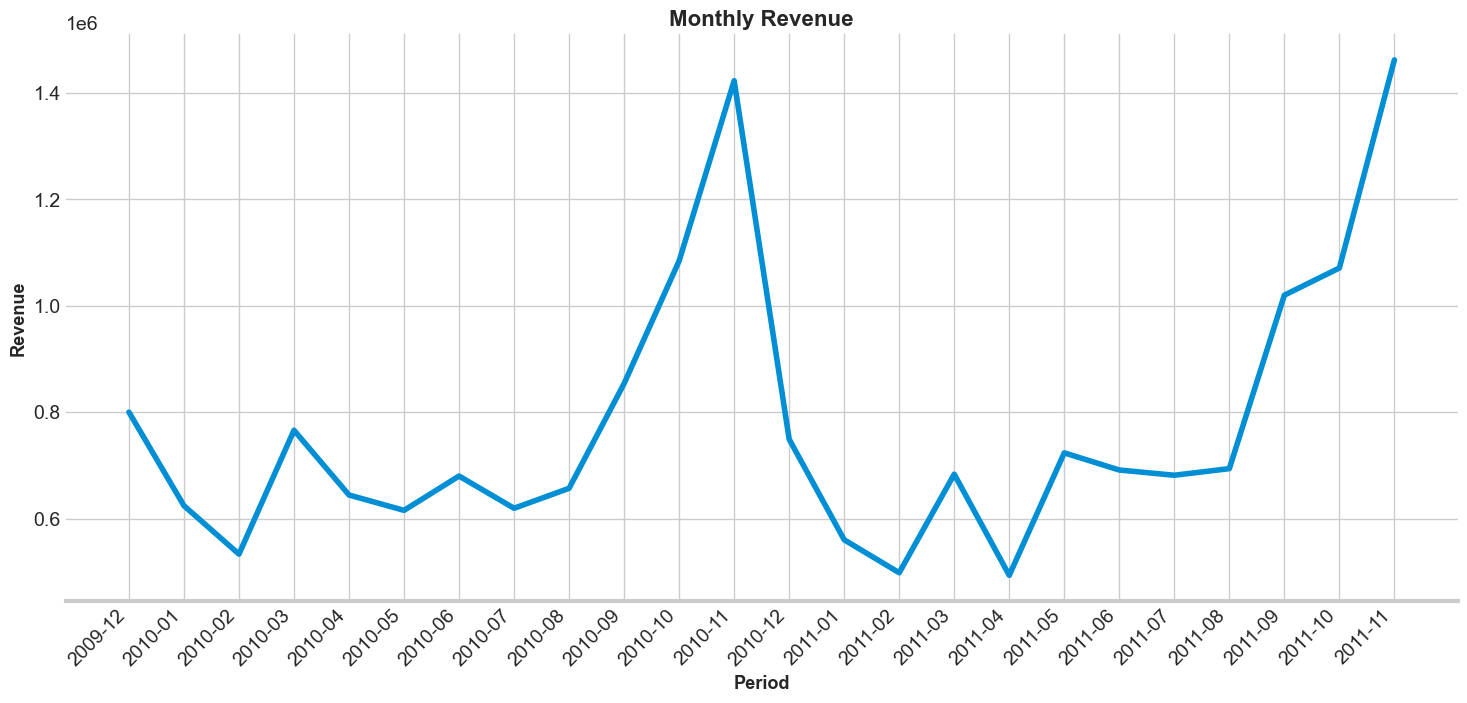

In [186]:
# get revenue per month

month_revenue = revenue_df.groupby('yy_mm', as_index=False).agg(total_revenue = ('revenue', 'sum'))
month_revenue['yy_mm'] = month_revenue['yy_mm'].astype(str)
# plot the MoM customer Registration
fig, ax = plt.subplots(figsize=(16,7))
chart = sns.lineplot(data=month_revenue.iloc[:-1, :], x='yy_mm', y='total_revenue', ax=ax)   # remove last 2019-12 from plt
sns.despine(left=True)

# Customize chart
chart.set_xlabel('Period',weight='bold',fontsize=13)
chart.set_ylabel('Revenue', weight='bold',fontsize=13)
chart.set_title('Monthly Revenue',weight='bold',fontsize=16)
chart.xaxis.set_major_locator(FixedLocator(range(month_revenue['yy_mm'].shape[0] - 1)))
chart.set_xticklabels(month_revenue['yy_mm'].iloc[:-1], rotation = 45, ha="right")
plt.show()


## Important Products

In [192]:
revenue_annual_growth = revenue_df.groupby(['StockCode', 'InvoiceYear']).agg(revenue=('revenue', 'sum'))
revenue_annual_growth = revenue_annual_growth.unstack('InvoiceYear')
revenue_annual_growth.columns = revenue_annual_growth.columns.droplevel(0)
revenue_annual_growth['total_revenue'] = revenue_annual_growth.sum(axis=1)
revenue_annual_growth.sort_values(by='total_revenue', ascending=False, inplace=True)

# drop the entries with total revenue is negative
revenue_annual_growth = revenue_annual_growth[revenue_annual_growth['total_revenue'] > 0]

# compute percent change in revenue per product from 2010 to 2011
revenue_annual_growth['pct_change_2010_11'] = (revenue_annual_growth.loc[:, 2011] - revenue_annual_growth.loc[:, 2010]) * 100 / revenue_annual_growth.loc[:, 2010]
revenue_annual_growth['pct_change_2010_11'] = revenue_annual_growth['pct_change_2010_11'].apply(lambda x: round(x, 2))

# filter to the top 10 important products
revenue_annual_growth.iloc[:10]


InvoiceYear,2009,2010,2011,total_revenue,pct_change_2010_11
StockCode,,,,,
22423,NaN,176648.64,137864.83,314513.47,-21.96
DOT,18574.58,109695.23,181574.29,309844.10,65.53
85123A,17247.70,142615.57,88815.54,248678.81,-37.72
85099B,6699.55,83635.98,88383.68,178719.21,5.68
47566,588.05,49474.14,97095.24,147157.43,96.25
84879,7610.41,66322.74,54973.86,128907.01,-17.11
22086,10169.36,51666.34,54586.79,116422.49,5.65
POST,2707.41,45860.36,61862.64,110430.41,34.89
79321,2171.64,31804.22,46261.62,80237.48,45.46


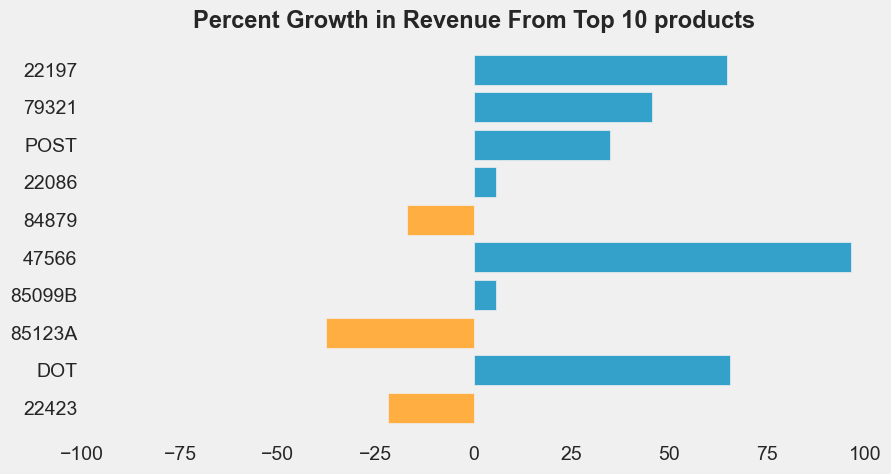

In [195]:
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(9, 5))
positive_clrs = revenue_annual_growth.iloc[:10]['pct_change_2010_11'] >= 0
color_map = positive_clrs.map({True:'#33A1C9',
                                      False:'#ffae42'}
                                    )
ax.barh(revenue_annual_growth.iloc[:10].index, revenue_annual_growth.iloc[:10]['pct_change_2010_11'], color=color_map)
ax.grid(visible=False)
ax.set_xlim(-100, 100)
ax.set_title('Percent Growth in Revenue From Top 10 products',weight = 'bold',size=17)
plt.show()